# Programa de Calores

En el presente programa se calcularán los calores involucrados en el proceso de adhesión de hielo con gota pequeña

In [1]:
import numpy as np
import pickle
import pandas as pd
from calculo_calores import analisis_termico_flujo
import matplotlib.pyplot as plt

In [2]:
objeto = analisis_termico_flujo()
help(objeto.calculo_todos_calores)
print(objeto)

Help on method calculo_todos_calores in module calculo_calores:

calculo_todos_calores(T_remanso, T_superficie, recovery_factor, p_remanso, LWC, cuerda, d, V, n_0, betha, m_in, T_s_anterior, cp_ws_anterior) method of calculo_calores.analisis_termico_flujo instance
    [Calcula todos los calores del problema. Ver la siguiente bibliografia:
        NASA, Manual of Scaling Methods
        BERNARD L. MESSINGER, Equilibrium Temperature of an Unheated Icing Surface as a Function of Air Speed]
    
    Arguments:
        T_pared_inicial {[float]} -- [Temperatura de la pared antes de la nebulizacion (K)]
        T_modelo {[float]} -- [Temperatura de la pared durante la nebulizacion (K)]
        T_superficie {[float]} -- [Temperatura de la superficie del hielo durante la nebulizacion (K)]
        recovery_factor {[float]} -- [factor de recuperacion ]
        p_remanso {[float]} -- [Presión de remanso del problema (Pa) suele ser 10^5]
        LWC {[float]} -- [contenido de agua líquida (g/m^3)]


Se empieza calculando el calor convectivo. Se ve que se necesita en primer lugar el coeficiente de convección, la T_superficie, la T_estatica, La velocidad del flujo y el coeficiente de presión

In [3]:
help(objeto.calor_convectivo)

Help on method calor_convectivo in module calculo_calores:

calor_convectivo(h_c, T_superficie, T_estatica, V) method of calculo_calores.analisis_termico_flujo instance
    Calcula el calor convectivo en la linea de remanso (manual
    scaling methods eq. 3.53)
    variables:
        h_c: film coefficient (cal/(hr m^2 K)
        T_superficie: K
        T_estatica: K
        V:Velocidad del flujo
        cp_a: coeficiente calorifico a presion cte
        q_h (cal/hr m^2)



Empezamos asignando los valores para cada una de las variables

# MVD = 20 $\mu m$ LWC =0.3 $g/m^{3}$

In [4]:

T_pared_inicial = -5.54+273.15 #K
T_modelo = -3.25+273.15
T_superficie =0+273.15 #K temperatura de la pared con el step
recovery_factor = 1 #En la linea de remanso (http://www.thermopedia.com/content/291/)
p_remanso = 1e5 #Pa
LWC = .3 #g/m^3
cuerda = 11.01 #cm
D_gota =20e-6 #m
d = 1.1 #cm
V=70 #m/s

T_estatica=T_pared_inicial -recovery_factor*V**2/1004.5 # K temperatura del flujo (estática)
T_remanso =T_estatica+1/(2*1004.5)*V**2
p_estatica = p_remanso/(1+V**2/(2*287*T_estatica))#Pa
rho_a = p_estatica/(.287*T_estatica) #g/m^3 (incompresible M<0.3)

Para el coeficiente convectivo:

In [5]:
help(objeto.film_coefficient)

Help on method film_coefficient in module calculo_calores:

film_coefficient(k_a, Nu_a, d) method of calculo_calores.analisis_termico_flujo instance
    Calcula el coeficiente convectivo
    Variables:
        ka: coeficiente de conductivo del aire (cal/(m K hr)
        Nu_a: Nº de Nusselt del aire
        d: diametro caracteristico del perfil (borde de ataque) (metros)



Ahora lo que se hace el saber como indicar todos los numeros involucrados en el flujo convectivo

In [6]:
help(objeto.Nusselt)
help(objeto.Pr)
help(objeto.Reynolds)
help(objeto.viscosity)
help(objeto.thermal_conductivity)
T_film = objeto.Temperatura_film(T_estatica,T_superficie)
k_a = objeto.thermal_conductivity(T_film)
mu_a = objeto.viscosity(T_estatica)
mu_film=objeto.viscosity(T_film)
Re = objeto.Reynolds(V, d, rho_a, mu_a)*10**-4
Re_film=objeto.Reynolds(V, d, rho_a, mu_film)*10**-4
Pr = objeto.Pr(objeto.cp_a, mu_film, k_a/360000)
Nu = objeto.Nusselt(Pr, Re_film)

Help on method Nusselt in module calculo_calores:

Nusselt(Pr, Re) method of calculo_calores.analisis_termico_flujo instance
    Ecuación (3.33) Manual de Scaling Methods (NASA)
    Pr: Nº de Prandtl
    Re: Nº De Reynolds

Help on method Pr in module calculo_calores:

Pr(cp_a, mu_a, k_a) method of calculo_calores.analisis_termico_flujo instance
    Numero de Prandtl (ecuacion 3.34)
    c_p: coeficiente calorifico a presion cte 
    mu_a  viscosidad
    k_a: conductividad termica

Help on method Reynolds in module calculo_calores:

Reynolds(V, c, rho, mu_a) method of calculo_calores.analisis_termico_flujo instance
    Numero de Reynolds (ecuacion 3.39)
    Se hace respecto a la cuerda
    rho_a: densidad
    c: cuerda del perfil
    mu_a viscosidad del aire
    V_velocidad del flujo

Help on method viscosity in module calculo_calores:

viscosity(T) method of calculo_calores.analisis_termico_flujo instance
    #g/(cm s)
    Viscosidad del aire en funcion de la temperatura

Help on metho

Se calcula el coeficiente convectivo y el flujo de calor por convección como: 

In [7]:
h_c = objeto.film_coefficient(k_a, Nu, d/100) #se pasa el diametro del perfil a metros
print(h_c)
q_convectivo = objeto.calor_convectivo(h_c, T_superficie, T_estatica, V)
print(str(q_convectivo*3600)+' cal/(hr m^2)')

449036.3440451166
3582871.9412419456 cal/(hr m^2)


## Calor por evaporación

In [8]:
help(objeto.heat_evaporation)

Help on method heat_evaporation in module calculo_calores:

heat_evaporation(m_e, Lambda_v) method of calculo_calores.analisis_termico_flujo instance
    Calcula el flujo de calor por evaporacion (cal/(m^2 hr)).
    m_e : la masa de aire que se evapora (g/(hr m^2))
    Lambda_v = calor latente de evaporacion  (cal/g)
    Se toma como incompresible



Primero se calcula la constante de transmision de masa por evaporación

In [8]:
help(objeto.convective_mass_coeff)
help(objeto.difusividad)
help(objeto.Schmidt)
difusividad = objeto.difusividad(T_film,p_estatica) #cm^2/s
difusividad=difusividad*10**(-4)
Sc = objeto.Schmidt(mu_a*100,rho_a,difusividad)
h_g = objeto.convective_mass_coeff(h_c, Sc, Pr) #g/(m^2 hr) 

Help on method convective_mass_coeff in module calculo_calores:

convective_mass_coeff(h_c, Sc, Pr) method of calculo_calores.analisis_termico_flujo instance
    Calcula el coeficiente de transmisión de masa
    Ecuacion A35 de manual scaling methods

Help on method difusividad in module calculo_calores:

difusividad(T_film, p_st) method of calculo_calores.analisis_termico_flujo instance
    Calcula la difusividad en funcion de la temperatura. 
    Ecuacion A.4 Manual de Scaling Methods

Help on method Schmidt in module calculo_calores:

Schmidt(mu_a, rho_a, Difusividad) method of calculo_calores.analisis_termico_flujo instance
    Numero de Schmidt (Sc)
    Difusividad del aire, mu_a viscosidad y rho_a es la densidad
    Ecuacion  3.48 Manual Scaling NASA



Ahora se calcula el calor latente de vaporización

In [9]:
Lambda_v =  objeto.Latent_heat_vaporisation(T_superficie) #cal/g

Finalmente se necesita la presión de vapor en la superficie ($p_{ww}$) y en el exterior ($p_{w}$). Cuando el agua esta en la superficie, se considera que está 0ºC más o menos, ya que las gotas pasan a esa temperatura de manera instantánea aunque la superficie no lo haga (ver $\textit{"Experimental and numerical analysis of the temperature transition of a suspended freezing water droplet"}$ J.P. Hindmarsh *, A.B. Russell, X.D. Chen)

In [10]:
help(objeto.presion_vapor)
p_w = objeto.presion_vapor(T_estatica)
p_ww = objeto.presion_vapor(T_superficie)
print('presion de vapor superficie (Pa):  '+str(p_ww))
print('presion de vapor en el flujo (Pa):  '+str(p_w))

Help on method presion_vapor in module calculo_calores:

presion_vapor(T) method of calculo_calores.analisis_termico_flujo instance
    Presion de vapor del agua en funcion del ratio de humedad
    Datos de Beltramino, G., Rosso, L., Cuccaro, R., Tabandeh, S., Smorgon, D., & Fernicola, V. (2019).
    Accurate vapour pressure measurements of super cooled water in the temperature range between 252 K and 273 K. 
    The Journal of Chemical Thermodynamics, 105944. doi:10.1016/j.jct.2019.105944

presion de vapor superficie (Pa):  611.0796410767697
presion de vapor en el flujo (Pa):  277.1759124302081


In [12]:
dot_me=objeto.mass_water_evaporation(p_ww,p_w,h_g,p_estatica,T_estatica,T_remanso,p_remanso,0.5)
q_evaporacion = objeto.heat_evaporation(dot_me,Lambda_v)/3600
print(str(q_evaporacion*3600)+' cal/(m^2 hr)')


2559307.6381267 cal/(m^2 hr)


## Heat lost from the surface to raise the temperature of the impinging liquid to the freezing point

La ecuacion de la pérdida de  calor de la superficie por la subida del agua hasta el punto de congelación:
$$q_{w} = \dot{m}c_{p,ws}(t_f-t_{st})$$
flujo másico por agua que impregna la superficie:


In [13]:
help(objeto.impinging_mass_water)
help(objeto.catch_efficiency_stagnation)
help(objeto.inertia_parameter)
help(objeto.dimensionless_range_parameter)
help(objeto.modified_inertia_parameter)

Help on method impinging_mass_water in module calculo_calores:

impinging_mass_water(LWC, V, betha_0) method of calculo_calores.analisis_termico_flujo instance
    impinging_mass_water Masa de agua que choca
    Ecuacion 3.50 Manual scaling methods
    LWC: liquid water content
    V: Velocidad del flujo
    betha_0 = catch efficiency at stagnation (eficiencia de adhesion en remanso)

Help on method catch_efficiency_stagnation in module calculo_calores:

catch_efficiency_stagnation(K_0) method of calculo_calores.analisis_termico_flujo instance
    Ecuacion 3.13 del Manual of Scaling Methods
    (betha_0)
    K_0 es el parametro de inercia (ver inertia_parameter)

Help on method inertia_parameter in module calculo_calores:

inertia_parameter(rho_w, delta, V, d, mu_a) method of calculo_calores.analisis_termico_flujo instance
    K=rho_w*delta**2*V/(18*d*mu_a)
    K is the non-dimensional inertia parameter
    defined by Langmuir and Blodgett  Eq. 3.5
    rho_w, densidad del agua
    delt

In [14]:
K=objeto.inertia_parameter(1e6, D_gota, V, d, mu_a)
LAMBDA_LAMBDAstokes= objeto.dimensionless_range_parameter(V,D_gota,rho_a,mu_a*100)
Re_delta = objeto.Reynolds(V,D_gota,rho_a,mu_a)
K_0 = objeto.modified_inertia_parameter(LAMBDA_LAMBDAstokes, K)
betha_0 =objeto.catch_efficiency_stagnation(K_0)

In [15]:
dot_m = objeto.impinging_mass_water(LWC, V, betha_0) # g m^-2 s^-1


Calculo el calor especifico del agua en la superficie:

In [16]:
cp_ws =objeto.cp_ws(T_superficie) ##cal/g K
print(cp_ws)

1.0074


In [17]:
q_w = objeto.Sensible_Heat_Water(cp_ws,dot_m,T_estatica)
print(str(q_w*3600)+' cal/(hr m^2)')

612821.8211134837 cal/(hr m^2)


## Calor por E. Cinética


In [18]:
help(objeto.heat_kinetic)

Help on method heat_kinetic in module calculo_calores:

heat_kinetic(V, dm_dt) method of calculo_calores.analisis_termico_flujo instance
    calor debido a Energia cinetica del flujo (cal/(m^2 s))S
    ver termino (10) del apartado 3.5
    dm_dt (kg/(s m^2):impinging_mass_water



In [19]:
q_k = objeto.heat_kinetic(V,dot_m*10**-3) #cal/m^2 s
print(str(q_k*3600)+' cal/(hr m^2)')

34168.80236662149 cal/(hr m^2)


In [20]:
Lambda_f = objeto.latent_heat_freezing(T_superficie) #cal/g
print(Lambda_f)

79.7


In [21]:
#cal/(g K)
phi = objeto.drop_energy_transfer(T_estatica,V,cp_ws*4.185*1000) #K
print(phi)

9.836924962926545


In [22]:
help(objeto.air_energy_transfer)
tetha = objeto.air_energy_transfer(T_superficie, T_remanso, V, h_g, h_c, p_ww, p_w, p_estatica, p_remanso, T_estatica,Lambda_v)
print(tetha)

Help on method air_energy_transfer in module calculo_calores:

air_energy_transfer(T_superficie, T_remanso, V, h_g, h_c, p_ww, p_w, p_estatica, p_remanso, T_estatica, Lambda_v) method of calculo_calores.analisis_termico_flujo instance
    Ecuacion A52 
    Air energy transfer
    pww: Pa presion de vapor del agua en la superficie
    P_st: Pa presion estatica
    p_w: Pa p vapor del agua en el flujo
    p_remanso: Pa
    T_remanso:
    T_st
    T_superficie
    P_remanso
    h_g:coeficiente de transmision de masa por evaporacion (cal/(hr m^2 hr))
    h_c:coeficiente de transmision de calor por conveccion (cal/(hr m^2 hr))
    cp_a : J/Kg K
    Lambda_v: calor por evaporacion (cal/g)

13.678580054427654


In [23]:
help(objeto.relative_heat_factor)
b =objeto.relative_heat_factor(LWC,cp_ws,betha_0,V,h_c/3600)
print(b)

Help on method relative_heat_factor in module calculo_calores:

relative_heat_factor(LWC, cp_ws, betha_0, V, h_c) method of calculo_calores.analisis_termico_flujo instance
    Ecuacion 3.55 del Manual Scaling Methods
    LWC (g/m^3)
    V (m/s)
    cp_ws (calor especifico del agua en la superficie) (cal/g)
    h_c: cal/(s m^2) coeficiente de transmision de calor convectivo
    b=LWC*V*betha_0*cp_ws/h_c

0.13099850554911172


In [24]:
n_0=objeto.freezing_fraction_stagnation(cp_ws,Lambda_f,phi,tetha,b)
print(n_0)

1.4441686701184868


In [25]:
n_0 =(q_evaporacion+q_convectivo-q_k+q_w)/(dot_m*Lambda_f)
print(n_0)

1.4441718280491502


In [26]:
cp_is =objeto.cp_is(T_superficie)

In [4]:
k_hielo = objeto.conductividad_hielo(T_superficie,T_modelo)
n=[]
Grosores =[]
for espesor in range(1,100):
    Grosor_capa_hielo=espesor*1e-3
    q_cond = objeto.heat_conduction(T_superficie,T_modelo,Grosor_capa_hielo,k_hielo)
    n_0 =0.
    n_1 =0.01
    i=0
    funcion_1=1000
    while ((i<1000) and abs(funcion_1)> 1e-3):
        q_rb = objeto.calor_flujo_agua(n_0,dot_m,dot_me,cp_ws,T_superficie)
        q_i = objeto.heat_from_ice(dot_m,n_0,T_superficie,cp_is)
        q_f=objeto.heat_freezing(dot_m,Lambda_f,n_0)
        funcion_0 =objeto.balance_calores(q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)
        q_rb = objeto.calor_flujo_agua(n_1,dot_m,dot_me,cp_ws,T_superficie)
        q_i = objeto.heat_from_ice(dot_m,n_1,T_superficie,cp_is)
        q_f=objeto.heat_freezing(dot_m,Lambda_f,n_1)
        funcion_1 =objeto.balance_calores(q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)
        dfuncion = (funcion_1-funcion_0)/(n_1-n_0)
        n_2 = n_1- funcion_1/dfuncion
        n_0=n_1
        n_1=n_2
        i+=1
    n.append(n_1)
    Grosores.append(espesor/10)
plt.figure()
plt.plot(Grosores,n)
plt.xlabel('Grosor (mm)')
plt.ylabel('n (freezing factor)')

NameError: name 'dot_m' is not defined

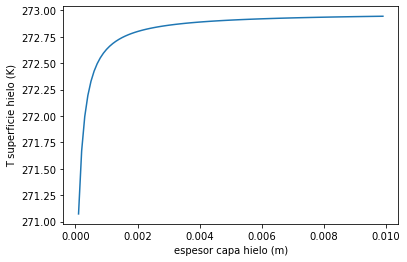

In [28]:
if n[-1]>1:
    Temp_superfice=[]
    Grosores=[g/10000 for g in range(1,100)]
    n=1
    for grosor in Grosores:
        T_su_0=T_superficie
        T_su_1=T_modelo
        funcion_1=100
        i=0
        while (abs(funcion_1)>1) and i <1000:
            (q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)=objeto.calculo_todos_calores(T_pared_inicial,T_modelo,                                                         T_su_0,recovery_factor,p_remanso,LWC,cuerda,D_gota,d,grosor,V,n)
            
            funcion_0 = objeto.balance_calores(q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)
            (q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)=objeto.calculo_todos_calores(T_pared_inicial,T_modelo,                                                         T_su_1,recovery_factor,p_remanso,LWC,cuerda,D_gota,d,grosor,V,n)
            funcion_1 = objeto.balance_calores(q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)
            df = (funcion_1-funcion_0)/(T_su_1-T_su_0)
            T_su_2 = T_su_1 -funcion_1/df
            T_su_0 =T_su_1
            T_su_1 = T_su_2
            i+=1
        
        Temp_superfice.append(T_su_2)
    plt.plot(Grosores,Temp_superfice)
    plt.xlabel('espesor capa hielo (m)')
    plt.ylabel('T superficie hielo (K)')

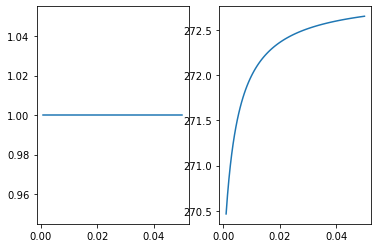

In [5]:
(n,Temp_superfice,Grosores)=objeto.resolucion_programa(T_pared_inicial,T_modelo,recovery_factor,p_remanso,LWC,cuerda,D_gota,d,5e-2,V)
fig, ax = plt.subplots(ncols=2,nrows=1)
ax[0].plot(Grosores,n)
ax[1].plot(Grosores,Temp_superfice)


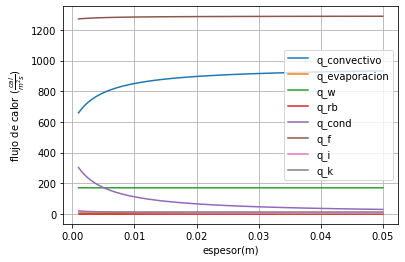

In [35]:

calores=[]
for i in range(len(n)):
    calores.append(list(objeto.calculo_todos_calores(T_pared_inicial,T_modelo,                                                         Temp_superfice[i],recovery_factor,p_remanso,LWC,cuerda,D_gota,d,Grosores[i],V,n[i])))
tabla=pd.DataFrame(data =calores,columns =['q_convectivo','q_evaporacion','q_w','q_rb','q_cond','q_f','q_i','q_k'])
tabla['n']=n
tabla['espesores']=Grosores
tabla['T_superficie']=Temp_superfice
#tabla.index=tabla['espesores']

tabla.plot(x='espesores',y=['q_convectivo','q_evaporacion','q_w','q_rb','q_cond','q_f','q_i','q_k'])
plt.xlabel('espesor(m)')
plt.ylabel(r'flujo de calor $(\frac{cal}{m^2 s})$')
plt.grid()
plt.savefig(col+'.pdf')

# LWC = 0.6 $g/m^3$ MVD =20 $\mu m$

In [30]:
T_pared_inicial = -4.82+273.15 #K
T_modelo = -0.99+273.15
T_superficie =0+273.15 #K temperatura de la pared con el step
recovery_factor = 1 #En la linea de remanso (http://www.thermopedia.com/content/291/)
p_remanso = 1e5 #Pa
LWC = .6 #g/m^3
cuerda = 11.01 #cm
D_gota =20e-6 #m
d = 1.1 #cm
V=70 #m/s


Text(0, 0.5, 'n (freezing factor)')

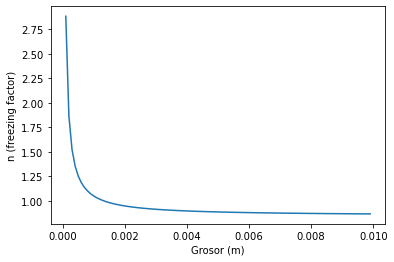

In [30]:
Grosores=[g/10000 for g in range(1,100)]
n=[]
for espesor in Grosores:
    Grosor_capa_hielo=espesor
    q_cond = objeto.heat_conduction(T_superficie,T_modelo,Grosor_capa_hielo,k_hielo)
    n_0 =0.
    n_1 =1
    i=0
    funcion_1=1000
    while ((i<1000) and abs(funcion_1)> 1):
        (q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)=objeto.calculo_todos_calores(T_pared_inicial,T_modelo,                                                         T_superficie,recovery_factor,p_remanso,LWC,cuerda,D_gota,d,Grosor_capa_hielo,V,n_0)
        funcion_0 =objeto.balance_calores(q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)
        (q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)=objeto.calculo_todos_calores(T_pared_inicial,T_modelo,                                                         T_superficie,recovery_factor,p_remanso,LWC,cuerda,D_gota,d,Grosor_capa_hielo,V,n_1)
        funcion_1 =objeto.balance_calores(q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)
        dfuncion = (funcion_1-funcion_0)/(n_1-n_0)
        n_2 = n_1- funcion_1/dfuncion
        n_0=n_1
        n_1=n_2
        i+=1
    
    n.append(n_1)
  
plt.figure()
plt.plot(Grosores,n)
plt.xlabel('Grosor (m)')
plt.ylabel('n (freezing factor)')

In [31]:
if n[-1]>1:
    Temp_superfice=[]
    Grosores=[g/10000 for g in range(1,100)]
    n=1
    for grosor in Grosores:
        T_su_0=T_superficie
        T_su_1=T_modelo
        funcion_1=100
        i=0
        while (abs(funcion_1)>1) and i <1000:
            (q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)=objeto.calculo_todos_calores(T_pared_inicial,T_modelo,                                                         T_su_0,recovery_factor,p_remanso,LWC,cuerda,D_gota,d,grosor,V,n)
            
            funcion_0 = objeto.balance_calores(q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)
            (q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)=objeto.calculo_todos_calores(T_pared_inicial,T_modelo,                                                         T_su_1,recovery_factor,p_remanso,LWC,cuerda,D_gota,d,grosor,V,n)
            funcion_1 = objeto.balance_calores(q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)
            df = (funcion_1-funcion_0)/(T_su_1-T_su_0)
            T_su_2 = T_su_1 -funcion_1/df
            T_su_0 =T_su_1
            T_su_1 = T_su_2
            i+=1
        
        Temp_superfice.append(T_su_2)
    plt.plot(Grosores,Temp_superfice)
    plt.xlabel('espesor capa hielo (m)')
    plt.ylabel('T superficie hielo (K)')


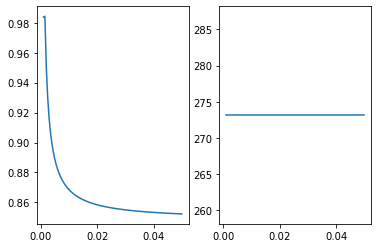

In [31]:
(n,Temp_superfice,Grosores)=objeto.resolucion_programa(T_pared_inicial,T_modelo,recovery_factor,p_remanso,LWC,cuerda,D_gota,d,5e-2,V)
fig, ax = plt.subplots(ncols=2,nrows=1)
ax[0].plot(Grosores,n)
ax[1].plot(Grosores,Temp_superfice)

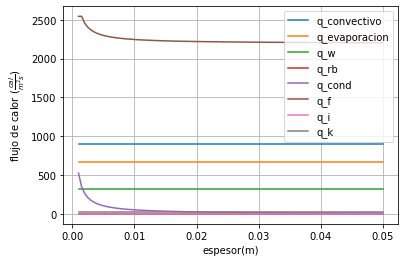

In [32]:

calores=[]
for i in range(len(n)):
    calores.append(list(objeto.calculo_todos_calores(T_pared_inicial,T_modelo,                                                         Temp_superfice[i],recovery_factor,p_remanso,LWC,cuerda,D_gota,d,Grosores[i],V,n[i])))
tabla=pd.DataFrame(data =calores,columns =['q_convectivo','q_evaporacion','q_w','q_rb','q_cond','q_f','q_i','q_k'])
tabla['n']=n
tabla['espesores']=Grosores
tabla['T_superficie']=Temp_superfice
#tabla.index=tabla['espesores']

tabla.plot(x='espesores',y=['q_convectivo','q_evaporacion','q_w','q_rb','q_cond','q_f','q_i','q_k'])
plt.xlabel('espesor(m)')
plt.ylabel(r'flujo de calor $(\frac{cal}{m^2 s})$')
plt.grid()
plt.savefig(col+'.pdf')

# LWC = 0.9 $g/m^3$ MVD =20 $\mu m$

In [27]:
T_pared_inicial = -5.62+273.15 #K
T_modelo = -1.07+273.15
T_superficie =0+273.15 #K temperatura de la pared con el step
recovery_factor = 1 #En la linea de remanso (http://www.thermopedia.com/content/291/)
p_remanso = 1e5 #Pa
LWC = .9 #g/m^3
cuerda = 11.01 #cm
D_gota =20e-6 #m
d = 1.1 #cm
V=70 #m/s

Text(0, 0.5, 'n (freezing factor)')

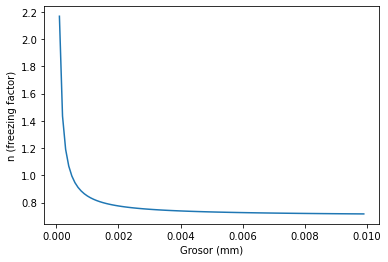

In [33]:
Grosores=[g/10000 for g in range(1,100)]
n=[]
for espesor in Grosores:
    Grosor_capa_hielo=espesor
    q_cond = objeto.heat_conduction(T_superficie,T_modelo,Grosor_capa_hielo,k_hielo)
    n_0 =0.
    n_1 =1
    i=0
    funcion_1=1000
    while ((i<1000) and abs(funcion_1)> 1):
        (q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)=objeto.calculo_todos_calores(T_pared_inicial,T_modelo,                                                         T_superficie,recovery_factor,p_remanso,LWC,cuerda,D_gota,d,Grosor_capa_hielo,V,n_0)
        funcion_0 =objeto.balance_calores(q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)
        (q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)=objeto.calculo_todos_calores(T_pared_inicial,T_modelo,                                                         T_superficie,recovery_factor,p_remanso,LWC,cuerda,D_gota,d,Grosor_capa_hielo,V,n_1)
        funcion_1 =objeto.balance_calores(q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)
        dfuncion = (funcion_1-funcion_0)/(n_1-n_0)
        n_2 = n_1- funcion_1/dfuncion
        n_0=n_1
        n_1=n_2
        i+=1
    
    n.append(n_1)
  
plt.figure()
plt.plot(Grosores,n)
plt.xlabel('Grosor (mm)')
plt.ylabel('n (freezing factor)')

In [34]:
if n[-1]>1:
    Temp_superfice=[]
    Grosores=[g/10000 for g in range(1,100)]
    n=1
    for grosor in Grosores:
        T_su_0=T_superficie
        T_su_1=T_modelo
        funcion_1=100
        i=0
        while (abs(funcion_1)>1) and i <1000:
            (q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)=objeto.calculo_todos_calores(T_pared_inicial,T_modelo,                                                         T_su_0,recovery_factor,p_remanso,LWC,cuerda,D_gota,d,grosor,V,n)
            
            funcion_0 = objeto.balance_calores(q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)
            (q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)=objeto.calculo_todos_calores(T_pared_inicial,T_modelo,                                                         T_su_1,recovery_factor,p_remanso,LWC,cuerda,D_gota,d,grosor,V,n)
            funcion_1 = objeto.balance_calores(q_convectivo,q_evaporacion,q_w,q_rb,q_cond,q_f,q_i,q_k)
            df = (funcion_1-funcion_0)/(T_su_1-T_su_0)
            T_su_2 = T_su_1 -funcion_1/df
            T_su_0 =T_su_1
            T_su_1 = T_su_2
            i+=1
        
        Temp_superfice.append(T_su_2)
    plt.plot(Grosores,Temp_superfice)
    plt.xlabel('espesor capa hielo (m)')
    plt.ylabel('T superficie hielo (K)')

In [8]:
(n,Temp_superfice,Grosores)=objeto.resolucion_programa(T_pared_inicial,T_modelo,recovery_factor,p_remanso,LWC,cuerda,D_gota,d,5e-2,V)


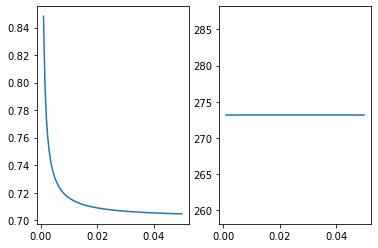

In [9]:
fig, ax = plt.subplots(ncols=2,nrows=1)
ax[0].plot(Grosores,n)
ax[1].plot(Grosores,Temp_superfice)

In [19]:

calores=[]
for i in range(len(n)):
    calores.append(list(objeto.calculo_todos_calores(T_pared_inicial,T_modelo,                                                         Temp_superfice[i],recovery_factor,p_remanso,LWC,cuerda,D_gota,d,Grosores[i],V,n[i])))
tabla=pd.DataFrame(data =calores,columns =['q_convectivo','q_evaporacion','q_w','q_rb','q_cond','q_f','q_i','q_k'])
tabla['n']=n
tabla['espesores']=Grosores
tabla['T_superficie']=Temp_superfice
#tabla.index=tabla['espesores']

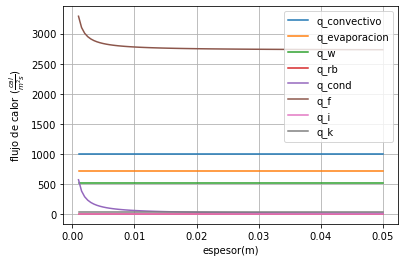

In [28]:

tabla.plot(x='espesores',y=['q_convectivo','q_evaporacion','q_w','q_rb','q_cond','q_f','q_i','q_k'])
plt.xlabel('espesor(m)')
plt.ylabel(r'flujo de calor $(\frac{cal}{m^2 s})$')
plt.grid()
plt.savefig(col+'.pdf')

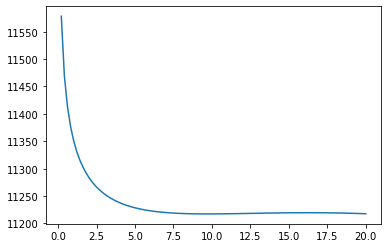

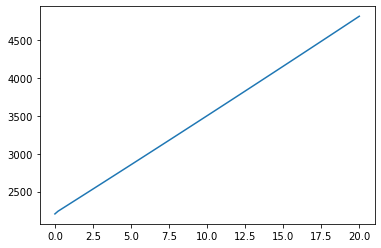

In [30]:
T_s = np.linspace(273.15,293.15,100)
objeto.calor_conductivo=False
calor_exterior=[]
for t_s in T_s:
    (q_c,q_e,q_w,q_rb,q_cond,q_f,q_i,q_k)=objeto.calculo_todos_calores(T_pared_inicial,t_s,recovery_factor,p_remanso,LWC,cuerda,D_gota,d,0.02,V,0,1,1)
    calor_exterior.append(-objeto.balance_calores(q_c,q_e,q_w,0,0,0,0,q_k))
plt.figure()
plt.plot(np.array(T_s)-273.15,calor_exterior)
    

In [ ]:
T_pared_inicial = -5.62+273.15 #K
T_modelo = -1.07+273.15
T_superficie =0+273.15 #K temperatura de la pared con el step
recovery_factor = 1 #En la linea de remanso (http://www.thermopedia.com/content/291/)
p_remanso = 1e5 #Pa
LWC = .9 #g/m^3
cuerda = 11.01 #cm
D_gota =20e-6 #m
d = 1.1 #cm
V=70 #m/s